In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, auc
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

import time

np.random.seed(seed=42)

class RandomForest():

    def __init__(self, Xtrain, Xtest, ytrain, ytest, balancing=None):
        '''
        Initialize RandomForest Classifier.
        '''
        print("-"*60)
        print(f"Initializing RandomForest Classifier")
        self.Xtrain = Xtrain
        self.Xtest = Xtest
        self.ytrain = ytrain
        self.ytest = ytest
        self.balancing = balancing
        
        #Resampling the dataset using Smote-Algorithm
        if self.balancing == 'SMOTE':
            sm = SMOTE(random_state = 42, n_jobs=-1)
            self.Xtrain, self.ytrain = sm.fit_resample(self.Xtrain, self.ytrain)
            

        self.model = RandomForestClassifier(class_weight="balanced_subsample",  n_jobs = -1)

        self.grid_search()
        

        self.grid_search_heatmap() 
        print("-"*60)
        print(f"Predicting with Test set")
        self.predict(self.Xtest, self.ytest)
        self.roc_curve()
        print("-"*60)
        print(f"Predicting with Train set")
        self.predict(self.Xtrain, self.ytrain)
        
        self.most_important_features()




    def grid_search(self):
        '''
        Grid Search with params provided, best models get stored in self.model
        '''
        print("-"*60)



        print("Performing Grid Search...")
        param_grid = {'n_estimators': [1, 10, 100, 200],
                    'min_samples_split': [2, 5, 10, 20, 30, 50, 70, 100]
                    }
                
        # As our classes are highly imbalanced, we aim to maximize f1 score
        self.grid = GridSearchCV(self.model, param_grid, scoring='f1', n_jobs=-1)
        self.grid.fit(self.Xtrain, self.ytrain)
        print('Best params after grid search', self.grid.best_params_)


        self.model = self.grid.best_estimator_

    def grid_search_heatmap(self):

        results = pd.DataFrame(self.grid.cv_results_)
        hm_data = results.pivot(index='param_min_samples_split', 
                           columns='param_n_estimators',
                           values='mean_test_score')

        # Plot heatmap
        fix, ax = plt.subplots(figsize=(9, 6))

        ax = sns.heatmap(hm_data,
                         annot=True,
                         cmap='RdBu',
                         linecolor='white')

        ax.set_title('Hyperparameter Gridsearch', fontsize=16)
        ax.set_ylabel('Min Samples Split', fontsize=12)
        ax.set_xlabel('Number of estimators', fontsize=12)
        plt.show()
        self.hm_data = hm_data
        arr = self.hm_data.to_numpy().flatten()

    def predict(self, X, y):
        '''
        Predict and print classification report
        '''
        print("-"*60)
        print('Predicting...')
        self.yfit = self.model.predict(X)
        self.y = y
        self.classification_report()




    def classification_report(self):
        '''
        Print Classification Report
        '''
        print("-"*60)
        print('Classification Report')
        print(classification_report(self.y, self.yfit, target_names=['0', '1']))
        tn, fp, fn, tp = confusion_matrix(self.y,  self.yfit).ravel()
        print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")


    def most_important_features(self):
        '''
        Report of the most important features for the model.
        '''
        print("-"*60)
        print('5 Most important Features')
        results = {}

        for name, importance in zip(self.Xtrain.columns, self.model.feature_importances_):
            results[name] = importance


        five_more_relevant = sorted(results.items(), key=lambda x: x[1], reverse=True)[:5]

        print("Columns with higher relative importance: ")
        for column in five_more_relevant:
            print(f"{column[0]} has a relative importance of {column[1]}")

        number_of_columns_in_chart = len(self.Xtrain.columns)
    
        all_columns = sorted(results.items(), key=lambda x: x[1], reverse=False)[-number_of_columns_in_chart:]
        fig = go.Figure(go.Bar(
            y=[item[0] for item in all_columns],
            x=[item[1] for item in all_columns],
            marker_color = ['blue'] * (number_of_columns_in_chart - 5) + ['blue']*5,
            orientation='h'))

        fig.update_layout(title_text=f'{number_of_columns_in_chart} Columns with the highest relevance')
        fig.show()


    def roc_curve(self):
        fpr, tpr, _ = roc_curve(self.ytest[:], self.yfit[:])
        roc_auc = auc(fpr, tpr)
        
        # Visualization

        plt_roc = plt.plot(fpr, tpr, color='tab:orange',
                lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt_roc = plt.plot([0, 1], [0, 1], color='tab:blue', lw=2, linestyle='--')
        plt_roc = plt.xlabel('False Positive Rate')
        plt_roc = plt.ylabel('True Positive Rate')
        plt_roc = plt.xlim([0.0, 1.0])
        plt_roc = plt.ylim([0.0, 1.05])
        plt_roc = plt.legend(loc="lower right")
        plt_roc = plt.title('Receiver operating characteristic')

In [2]:
df = pd.read_csv('Csv/spotify_preprocessed.csv')

In [3]:
df_sample = df

In [4]:
def split_dataset(df=df, sample=1):
    df = df.sample(int(sample * df.shape[0]))
    Xtrain, Xtest, ytrain, ytest = train_test_split(df.loc[:, df.columns != 'label'], df.label, test_size=0.2, random_state=42)
    print(f" Train: {Xtrain.shape}\n" f"Test: {Xtest.shape}\n")


    return Xtrain, ytrain, Xtest, ytest


------------------------------------------------------------
Initializing RandomForest Classifier
------------------------------------------------------------
Performing Grid Search...


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best params after grid search {'min_samples_split': 2, 'n_estimators': 200}


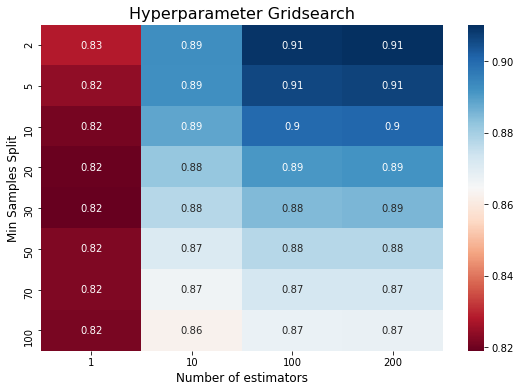

------------------------------------------------------------
Predicting with Test set
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.91      0.92    103625
           1       0.38      0.52      0.44     11498

    accuracy                           0.87    115123
   macro avg       0.66      0.72      0.68    115123
weighted avg       0.89      0.87      0.88    115123

TN: 93864
FP: 9761
FN: 5463
TP: 6035
------------------------------------------------------------
Predicting with Train set
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    414273
           1       1.00      1.00     

Time Elapsed:3131.0676901340485


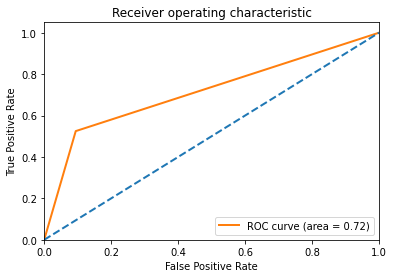

In [7]:
forest_start_time = time.time()

rcf = RandomForest(Xtrain=Xtrain,
                   Xtest=Xtest, 
                   ytrain=ytrain, 
                   ytest=ytest,
                  balancing='SMOTE')

forest_end_time = time.time()

print(f"Time Elapsed:{forest_end_time - forest_start_time}")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=efdb1931-d19c-4850-b12b-726a7087f8c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>